In [ ]:
# ! pip install -U tqdm 

In [ ]:
import os
import json
import math

from glob import glob
from tqdm import tqdm

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from utils.drawing import plot_one_box, draw_text
from utils.bboxes import box_iou

In [ ]:
res_path = "/home/kos/projects/PhD/ZebraFish/tinyROI/metrics/val-fixed-seq-empty-added-test-rotate-IBS/track-fix/results-ZebraFish-03-imgF.json"
CONF_TH = 0.3
FILT_TH = 0.7
out_dir = 'test/iou_conf' #'IBS_C03_I07_frame' #  f'/home/kos/projects/PhD/ZebraFish/tinyROI/metrics/val-fixed-seq-empty-added-test-rotate-IBS/roi-fix/before-after-{FILT_TH}-{CONF_TH}'

In [ ]:
def draw_dets_and_windows(img, dets, windows, vis_conf_th=0.1):
    for i, window in enumerate(windows):
        img = plot_one_box(list(map(int, window)), img, color=(0,0,180), label=f'WINDOW {i}', line_thickness=2, draw_label=False)
        xmin,ymin,xmax,ymax = window
    for i, det in enumerate(dets.tolist()):
        xmin,ymin,xmax,ymax = det[:4]
        img = plot_one_box(list(map(int, [xmin,ymin,xmax,ymax])), img, color=(180,20,20), 
                             label=f'DET {i}', line_thickness=1, draw_label=False)
        
        
    # stats = ["WINDOWS   %02d" % len(windows.tolist()), "DETS   %02d" % len(dets.tolist())]
    # img = draw_text(img, "\n".join(stats), 20, 40, color=(255,255,255))
    return img


def filter_dets_in_window(window, dets, other_dets, th=FILT_TH): # th=0.8):
    intersection_maxs = torch.min(other_dets[:, None, 2:], window[:, 2:]) # xmax, ymax
    intersection_mins = torch.max(other_dets[:, None, :2], window[:, :2]) # xmin, ymin
    # print(intersection_mins, intersection_maxs)
    intersections = torch.flatten(torch.cat((intersection_mins, intersection_maxs), dim=2), start_dim=0, end_dim=1)
    intersections[(intersections[:,2] - intersections[:,0] < 0) | (intersections[:,3] - intersections[:,1] < 0)] = 0
    
    ious = box_iou(intersections, dets)
    to_del = torch.where(ious > th)[1]
    dets_filtered = dets[[x for x in range(dets.shape[0]) if x not in to_del],:]
    return dets_filtered, intersections, ious, dets[[x for x in range(dets.shape[0]) if x in to_del],:]


def filter_dets_in_window_single_matrix(bboxes, windows, th=0.7):
    
    def normalize(input_tensor):
        input_tensor -= input_tensor.min(0, keepdim=True)[0]
        input_tensor /= input_tensor.max(0, keepdim=True)[0]
        return input_tensor
    unique_windows = torch.unique(windows, dim=0)
    
    intersection_maxs = torch.min(bboxes[:, None, 2:4], unique_windows[:, 2:4]) # xmax, ymax
    intersection_mins = torch.max(bboxes[:, None, :2], unique_windows[:, :2]) # xmin, ymin
    intersections = torch.cat((intersection_mins, intersection_maxs), dim=2)
    intersections[(intersections[:,:,2] - intersections[:,:,0] < 0) | (intersections[:,:,3] - intersections[:,:,1] < 0)] = 0 # no common area
    
    # # detections from window = 0
    # for i, unique_window in enumerate(unique_windows):
    #     win_ind = torch.unique(torch.where(windows==unique_window)[0])
    #     intersections[win_ind, i, :] = 0
    # # print(intersections.shape, bboxes.shape)
    
    ious = torch.empty((len(bboxes), len(unique_windows), len(bboxes)))
    for i in range(intersections.shape[1]):
        ious[:,i,...] = box_iou(intersections[:,i,:], bboxes[:,:4])
        
    for i in range(bboxes.shape[0]):
        ious[i,:,i] = 0
    
    #print(ious)
    to_del = torch.nonzero(ious > th)
    ious = ious[ious > th]
    
    if not ious.numel():
        return bboxes

    # to_del = torch.hstack((to_del, ious.unsqueeze(-1)))
    # to_del = to_del[to_del[:, -1].sort(descending=True)[1]] # (N, 4)
    det_ind = to_del[:,2].to(int)
    
    confs, areas = [], []
    for i in det_ind:
        xmin,ymin,xmax,ymax,conf = bboxes[i,:]
        confs.append(conf.item())
        areas.append((xmax-xmin)*(ymax-ymin))
        
    confs = 1 - normalize(torch.tensor(confs).unsqueeze(-1))
    areas = 1 - normalize(torch.tensor(areas).unsqueeze(-1))
    ious = normalize(ious.unsqueeze(-1))
    # print(ious)
    # print(confs)
    # # print(normalize(confs))
    # print(areas)
    # print(normalize(areas))
    mean = torch.mean(torch.stack([ious,confs, areas]), 0)
    # print(mean)
    
    to_del = torch.hstack((to_del, mean)) #torch.hstack((to_del, ious))
    to_del = to_del[to_del[:, -1].sort(descending=True)[1]] # (N, 4)
    det_ind = to_del[:,2].to(int)
    
    to_del_ids = []
    for i in range(to_del.shape[0]):
        if to_del[i, 0].item() in to_del_ids:
            #print(f'Cause already deleted {to_del[i, 0]}')
            continue
        if to_del[i, 2].item() in to_del_ids:
            #print(f'Detection already deleted {to_del[i, 2]}')
            continue
        to_del_ids.append(int(to_del[i, 2].item()))
        #print(f'Delete {to_del[i, 2]} because of {to_del[i, 0]}, iou: {to_del[i, 3]}')
    bboxes_filtered = bboxes[[x for x in range(bboxes.shape[0]) if x not in to_del_ids],:]
    # print(bboxes_filtered)
    return bboxes_filtered

 26%|██████████████▊                                           | 459/1800 [00:00<00:01, 1210.75it/s]


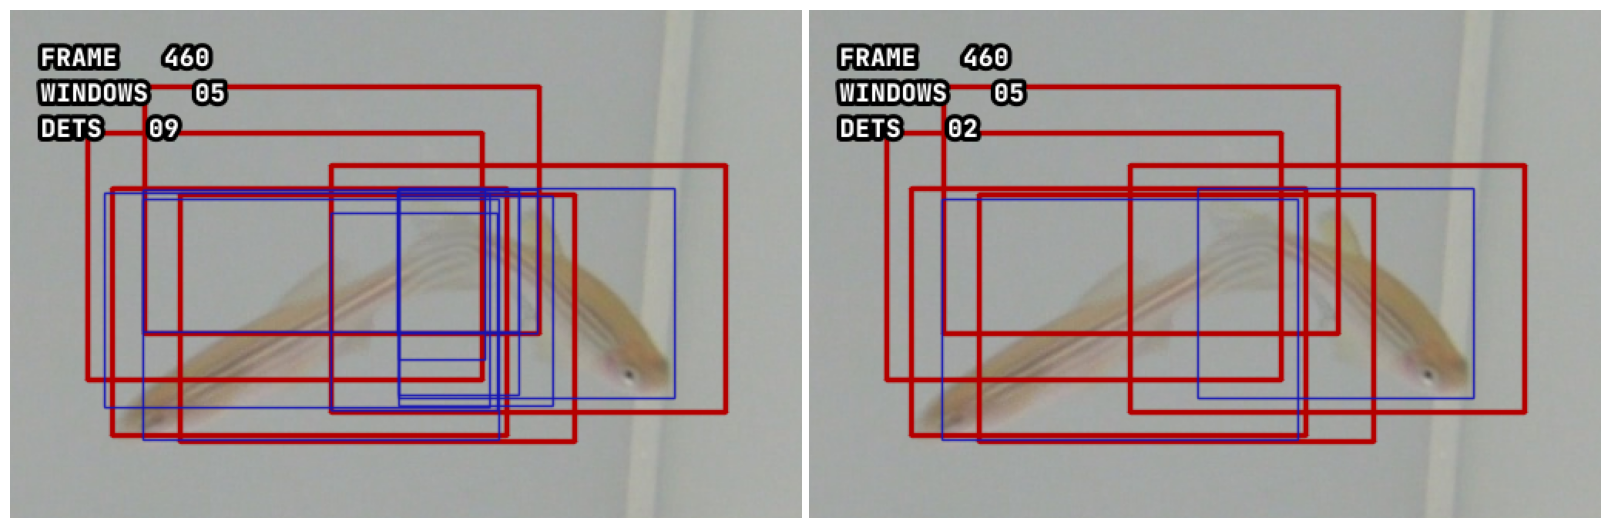

In [12]:
# plt.ioff()
os.makedirs(out_dir, exist_ok=True)
results = json.load(open(res_path))

unique_frames = sorted(list(set([x['image_path'] for x in results])))

for unique_frame in tqdm(unique_frames):
    
    if int(os.path.basename(os.path.splitext(unique_frame)[0])) < 460: #457: #689: #469: #284: #469:
        continue
    
    res = [x for x in results if x['image_path']==unique_frame]
    bboxes = torch.tensor([x['bbox']+[x['score']] for x in res])
    im = cv2.imread(res[0]['image_path'])
    
    windows = torch.empty((0,4)).to(torch.int32)
    if 'window_bbox' in res[0].keys():
        windows = torch.tensor([x['window_bbox'] for x in res]).to(torch.int32)
        
    # check all windows with all bboxes
    # step 0 sort by confidence (low conf first to remove)
    # step 1 intersections [all_dets, all_windows]
    # step 2 set coords to 0 - no intersection, bboxes detected on specific window
    # step 3 iou(all_intersections, all_dets) - remove dets with ious > th (column index)
    # NMS & OBS in one step
    
    
    indices = torch.where(bboxes[:,-1] > CONF_TH)[0]
    bboxes = bboxes[indices,:]
    
    
    
    
    # conf_asc_ind = bboxes[:,-1].argsort()
    # areas = bboxes[:,2]*bboxes[:,3]
    # # print(areas)
    # area_asc_ind = areas.argsort()
    # print(area_asc_ind)
    # bboxes = bboxes[:,:-1].to(torch.int32)
    bboxes[:,2] = bboxes[:, 0]+bboxes[:,2]
    bboxes[:,3] = bboxes[:, 1]+bboxes[:,3]
    
    
    
    # bboxes = bboxes[conf_asc_ind]
    # bboxes = bboxes[area_asc_ind]

    if 'window_bbox' not in res[0].keys():
        im_before = draw_dets_and_windows(im, bboxes, windows, vis_conf_th=CONF_TH)
        im = np.hstack((im_before, im_before))
        cv2.imwrite(f"{out_dir}/{os.path.basename(res[0]['image_path'])}", im)
        continue
        
    windows = windows[indices,:]
    # windows = windows[conf_asc_ind]
    # print(windows)
    # windows = windows[area_asc_ind]
    # print(windows)
    unique_windows = torch.unique(windows, dim=0) #, sorted=False)
    # print(bboxes)
    # print(windows)
    xmin, ymin = max(0, torch.min(unique_windows[:, 0]).item()-50), max(0, torch.min(unique_windows[:, 1]).item()-50)
    xmax, ymax = min(im.shape[1], torch.max(unique_windows[:, 2]).item()+50), min(im.shape[0], torch.max(unique_windows[:, 3]).item()+50)
    
    
    im_before = draw_dets_and_windows(im.copy(), bboxes, unique_windows, vis_conf_th=CONF_TH)[ymin:ymax, xmin:xmax, ::-1]
    stats = ["FRAME   %02d" % int(os.path.basename(os.path.splitext(unique_frame)[0])), "WINDOWS   %02d" % len(unique_windows.tolist()), "DETS   %02d" % len(bboxes.tolist())]
    im_before = draw_text(im_before, "\n".join(stats), 20, 20, color=(255,255,255), frac=0.02)

    filtered = filter_dets_in_window_single_matrix(bboxes, windows)
    dets_after = filtered
    dets_after = torch.unique(dets_after, dim=0)
    
#     dets_after = torch.empty((0,4))
#     images = []
#     for w, unique_window in enumerate(unique_windows):
#         ind_win = torch.unique(torch.where(windows==unique_window)[0])
#         ind_notwin = torch.unique(torch.where(windows!=unique_window)[0])
#         window_dets = bboxes[ind_win,:]
#         other_dets = bboxes[ind_notwin,:]

#         _, inter, ious, to_del = filter_dets_in_window(unique_window.unsqueeze(0), window_dets, other_dets)
#         for i in range(ious.shape[0]):
#             intersection = inter[i, :]
#             other_det = other_dets[i, :]

#             if torch.count_nonzero(intersection) == 0:
#                 continue

#             im_inter = im.copy()   
#             im_inter = plot_one_box(other_det.tolist(), im_inter, color=(150,150,150), label=f'DET', line_thickness=3, draw_label=True)
#             im_inter = plot_one_box(tuple(unique_window.tolist()), im_inter, color=(150,150,150), label=f'WIN{w}', line_thickness=3, draw_label=True)
#             # im_inter = plot_one_box(tuple(intersection.tolist()), im_inter, color=(40,40,180), label=f'INTER', line_thickness=2, draw_label=True)

#             for j in range(ious.shape[1]):
#                 iou = ious[i,j]
#                 det = window_dets[j,:]
                
#                 im_inter_copy = im_inter.copy()
#                 im_inter_copy = plot_one_box(det, im_inter_copy, color=(40,40,180), label=f'DET{w}', line_thickness=3, draw_label=True)
#                 im_inter_copy = plot_one_box(tuple(intersection.tolist()), im_inter_copy, color=(40,40,180), label=f'INTER', line_thickness=1, draw_label=False)
#                 im_inter_copy = im_inter_copy[ymin:ymax,xmin:xmax,::-1].astype(np.uint8)
#                 txt = f'IOU (DET{w}, INTER(WIN{w}, DET)): {iou:.2f}' if iou <= FILT_TH else f'IOU (DET{w}, INTER(WIN{w}, DET)): {iou:.2f} [DEL]'
#                 im_inter_copy = draw_text(im_inter_copy, txt, 20, 20, color=(255,255,255), frac=0.018)
        #         images.append(im_inter_copy)    
        # dets_after = torch.cat((dets_after, filtered))
        # dets_after = torch.unique(dets_after, dim=0)
         
        # # avoid filtering "same detection" twice (same objects)
        # to_del_orig = []
        # for r,row in enumerate(bboxes):
        #     if row.tolist() in to_del.tolist():
        #         to_del_orig.append(r)
                
        # bboxes = bboxes[[x for x in range(bboxes.shape[0]) if x not in to_del_orig],:]
        # windows = windows[[x for x in range(windows.shape[0]) if x not in to_del_orig],:]

    im_after = draw_dets_and_windows(im.copy(), dets_after, unique_windows, vis_conf_th=CONF_TH)[ymin:ymax, xmin:xmax, ::-1]
    stats = ["FRAME   %02d" % int(os.path.basename(os.path.splitext(unique_frame)[0])), "WINDOWS   %02d" % len(unique_windows.tolist()), "DETS   %02d" % len(dets_after.tolist())]
    im_after = draw_text(im_after, "\n".join(stats), 20, 20, color=(255,255,255), frac=0.02)

    images = [im_before, im_after]
#     images = [im_before]+images+[im_after]
    H,W = ymax-ymin, xmax-xmin
    # print(H,W)
    shape_y, shape_x = 1,2 #math.ceil(len(images)/5), 5
    shape = shape_x * shape_y
    fig, axs = plt.subplots(shape_y, shape_x, figsize=(W/50*shape_x, H/50*shape_y))
    fig.subplots_adjust(hspace = .005, wspace=.005)
    axs = axs.ravel()

    for i in range(shape):
        if i >= len(images):
            axs[i].axis("off")
            continue
        _ = axs[i].imshow(images[i])
        axs[i].axis("off")
    
    # print(f"{out_dir}/{os.path.basename(res[0]['image_path'])}")
    fig.savefig(f"{out_dir}/{os.path.basename(res[0]['image_path'])}", bbox_inches='tight', pad_inches=0)
    # plt.close()
    
    if int(os.path.basename(os.path.splitext(unique_frame)[0])) == 460: #457: #57: #689:
        break
    
plt.ion()